### Python for street networks part 1

Retrieve, construct, analyze, and visualize street networks from OpenStreetMap

Code at Github: https://github.com/gboeing/osmnx

For the function docs: https://osmnx.readthedocs.io/en/stable/osmnx.html

For a nice intro on his blog: http://geoffboeing.com/2016/11/osmnx-python-street-networks/

### the basics

OSMnx is a Python package that lets you download **spatial geometries** and construct, project, visualize, and analyze street networks from OpenStreetMap's APIs. Users can download and construct walkable, drivable, or bikable urban networksand then easily analyze and visualize them.

In [1]:
# get the modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx

from sklearn.neighbors import KDTree
import folium
ox.config(use_cache=True, log_console=True)
print (ox.__version__)
print (nx.__version__)

# paths
OUTPUT_PATH = '../images/'

0.8.1
2.1


In [2]:
# graph figure settings
graph_settings = {'fig_height' :10, 
                  'fig_width' :12, 
                  'node_color' :'#F42334',
                  'edge_color' :'#253F51', 
                  'edge_alpha' :.5, 
                  'node_alpha' : 1}

arrow_settings = {'arrowstyle' :"->", 
                 'connectionstyle' : "angle3,angleA=0,angleB=-90",
                 'color': '#49a347'}
bbox_settings = {'boxstyle': "round4,pad=.5", 'fc': "0.9"}

# https://www.colorbook.io/colorschemes

## Create a networkx graph 

**graph_from_place** from OSM data within the spatial boundaries of some geocodable place(s)

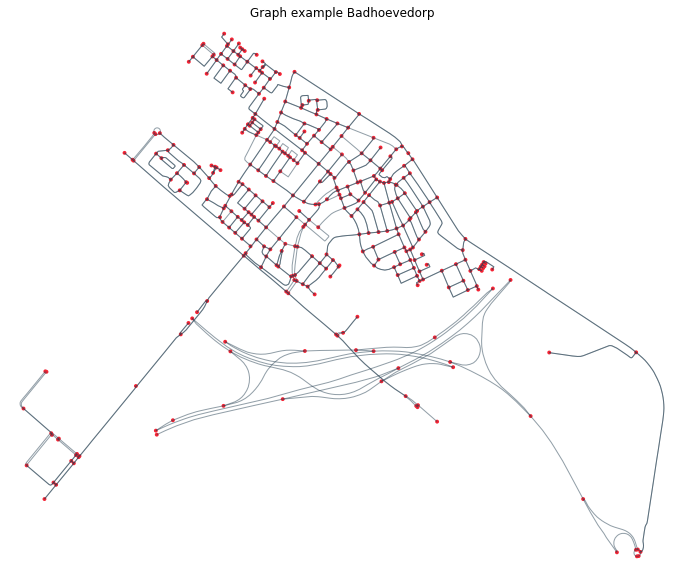

In [3]:
G = ox.graph_from_place('badhoevedorp, Netherlands', network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(G), show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example Badhoevedorp')

## steps --
## --> graph_from_place --> project_graph UTM = Universele transversale mercatorprojectie
## --> plot_graph

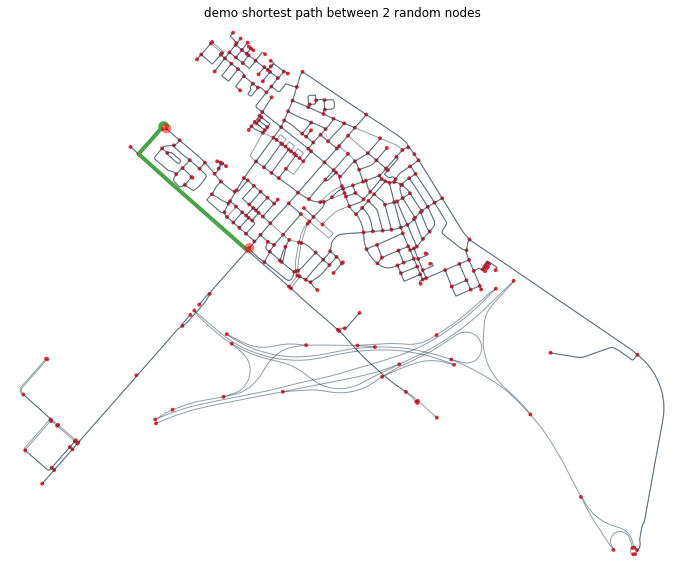

In [10]:
# shortest path between 2 random nodes
route = nx.shortest_path(G, source = np.random.choice(G.nodes), target = 
                         np.random.choice(G.nodes))
fig, ax = ox.plot_graph_route(G, route, show=False, close=False, **graph_settings, 
                              route_color = '#49a347', route_alpha=1)
_ = ax.set(title = 'demo shortest path between 2 random nodes')

**graph_from_address** Create a networkx graph from OSM data within some distance of some address.

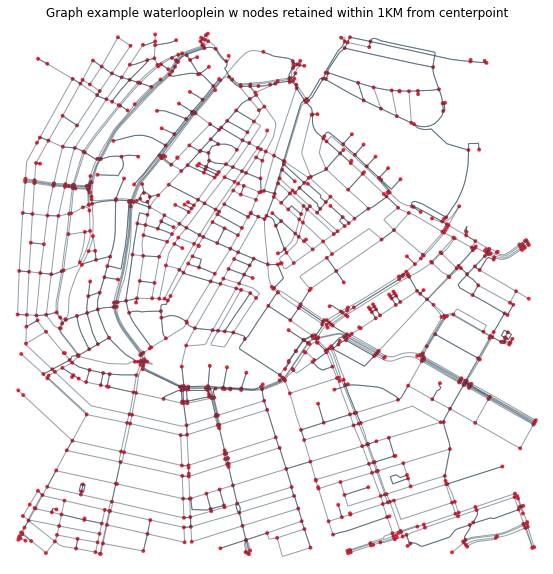

In [11]:
# get a street network and plot it with all edge intersections
address = 'waterlooplein, amsterdam'
G = ox.graph_from_address(address, network_type='bike', distance=1000)
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example waterlooplein w nodes retained within 1KM from centerpoint')

In [12]:
start = ox.geocode('Weesperstraat 113, Amsterdam')
end = ox.geocode('oudezijds voorburgwal 300, amsterdam')
print (start) #datalab
print (end) # oz

(52.3630173, 4.9072382)
(52.3712198, 4.8953522)


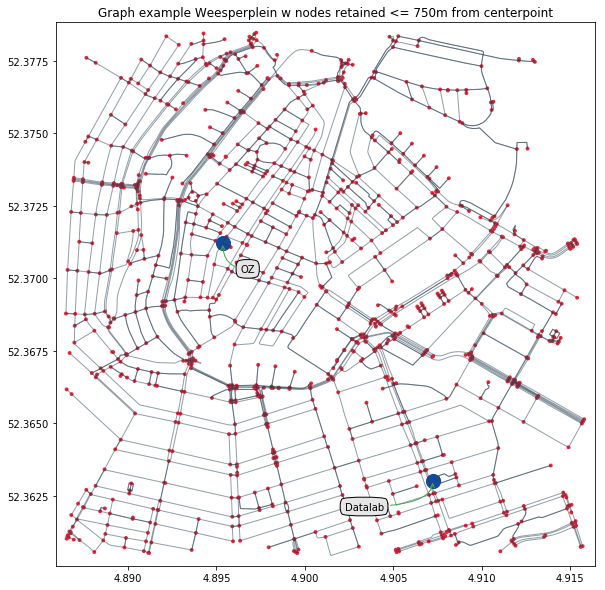

In [13]:
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings, axis_off=False)
#annotate plot
_ = ax.set(title = 'Graph example Weesperplein w nodes retained <= 750m from centerpoint')
ax.scatter(end[1], end[0], c='#144a9c', s=200)
ax.scatter(start[1], start[0], c='#144a9c', s=200)
ax.annotate('OZ', xy = (end[1], end[0]), 
            xytext=(end[1] +.001, end[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
ax.annotate('Datalab', xy = (start[1], start[0]), 
            xytext=(start[1] -.005, start[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
plt.show()

### KDTree for fast generalized N-point problems

A k-d tree makes finding our optimal nodes easy and efficient. The last two lines identify the Node IDs.

 **KD-tree search steps**
 
 - pick a random atrribute
 - for that attribute find the median and use this to split the dataset (half of datapoint on 1 side) = balanced data structure
 - continue this procedure 
 - use this to find your neigherst neighbours for a newly selected point (datalab / OZ data point in this case) --> find the regions of the data this Point geometry is contained in and compare to all Points in this region. Recursively select to suibtree to search in.

In [22]:
tree = KDTree(nodes[['y', 'x']], metric='euclidean', leaf_size= 10)

start_idx = tree.query([start], k=1, return_distance=False)[0]
end_idx = tree.query([end], k=1, return_distance=False)[0]
closest_node_to_start = nodes.iloc[start_idx].index.values[0]
closest_node_to_end = nodes.iloc[end_idx].index.values[0]

route = nx.shortest_path(G, closest_node_to_start, closest_node_to_end)
print ('list of nodes between : {} and {} = {}'.format(start_idx, end_idx, route))

list of nodes between : [392] and [222] = [1825801483, 46346752, 46349945, 46351200, 46350963, 46348792, 46351322, 46354504, 46355782, 46360568, 1307649106, 46362733, 3907020119, 3907020120, 46363000, 3188225083, 25752666, 46369715, 46369862, 46370164, 46370468, 46377925, 725239288, 46379586, 46380375, 46381175, 318452533]


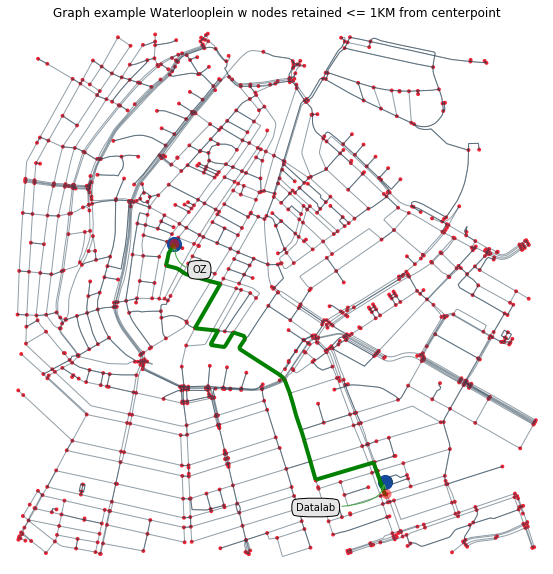

In [25]:
fig, ax = ox.plot_graph_route(G, route, show=False, close=False, **graph_settings,
                         route_color = 'green', route_alpha=1)
_ = ax.set(title = 'Graph example Waterlooplein w nodes retained <= 1KM from centerpoint')
ax.scatter(end[1], end[0], c='#144a9c', s=200)
ax.scatter(start[1], start[0], c='#144a9c', s=200)

ax.annotate('OZ', xy = (end[1], end[0]), 
            xytext=(end[1] +.001, end[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
ax.annotate('Datalab', xy = (start[1], start[0]), 
            xytext=(start[1] -.005, start[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)

plt.show()

In [26]:
# plot on folium --> folium builds on strengths of the Python ecosystem + 
# mapping strengths of the Leaflet.js library. (open-source JavaScript library)
m = ox.plot_route_folium(G, route, route_color='green')
folium.Marker(location=start,
              icon=folium.Icon(color='red'), popup='Datalab').add_to(m)
folium.Marker(location=end,
              icon=folium.Icon(color='blue'), popup='OZ').add_to(m)
m

### basic stats

Calculate basic descriptive metric and topological stats for a graph.

Here we can use all the shapely functions

In [120]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G) 
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area 
graph_area_m

3772709.16784563

In [121]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.0228546489361068,
 'clean_intersection_count': 443,
 'clean_intersection_density_km': 117.42225024278004,
 'edge_density_km': 37000.60136883352,
 'edge_length_avg': 53.648158339738586,
 'edge_length_total': 139592.5079999998,
 'intersection_count': 1074,
 'intersection_density_km': 284.67606492267663,
 'k_avg': 4.318672199170124,
 'm': 2602,
 'n': 1205,
 'node_density_km': 319.39912312088023,
 'self_loop_proportion': 0.0,
 'street_density_km': 28209.56460335204,
 'street_length_avg': 57.52782864864855,
 'street_length_total': 106426.48299999982,
 'street_segments_count': 1850,
 'streets_per_node_avg': 3.166804979253112,
 'streets_per_node_counts': {0: 0,
  1: 131,
  2: 38,
  3: 562,
  4: 454,
  5: 14,
  6: 5,
  7: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1087136929460581,
  2: 0.03153526970954357,
  3: 0.46639004149377594,
  4: 0.3767634854771784,
  5: 0.011618257261410789,
  6: 0.004149377593360996,
  7: 0.0008298755186721991}}

### cleaning up a network

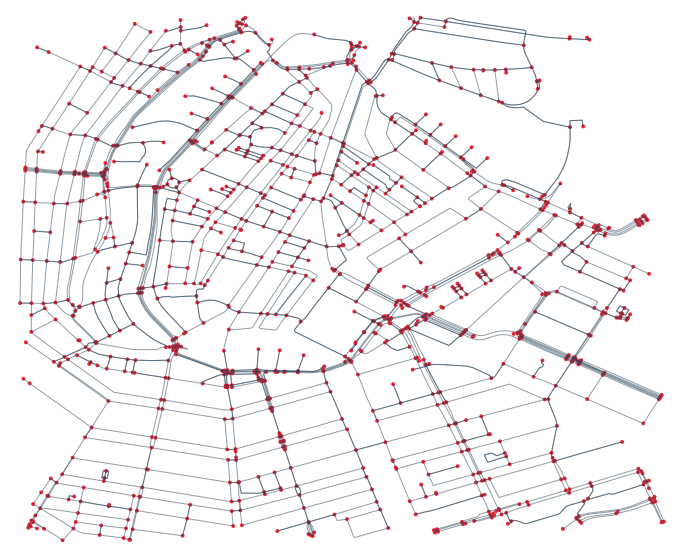

In [27]:
# get a street network and plot it with all edge intersections
G_proj = ox.project_graph(G) # to UTM
fig, ax = ox.plot_graph(G_proj, **graph_settings)

**Clean up the intersections**

We'll specify that any nodes with 10 meters of each other in this network are part of the same intersection. 

- Adjust this tolerance based on the street design standards
- use a projected graph to work in meaningful units like meters. 
- specify that we do not want dead-ends returned in our list of cleaned intersections. 
- extract xy coordinates 
- plot clean intersections compared to the topological edge intersections above.

In [32]:
# clean up the intersections and extract their xy coords
intersections = ox.clean_intersections(G_proj, tolerance=10, dead_ends=False)
points = np.array([point.xy for point in intersections])

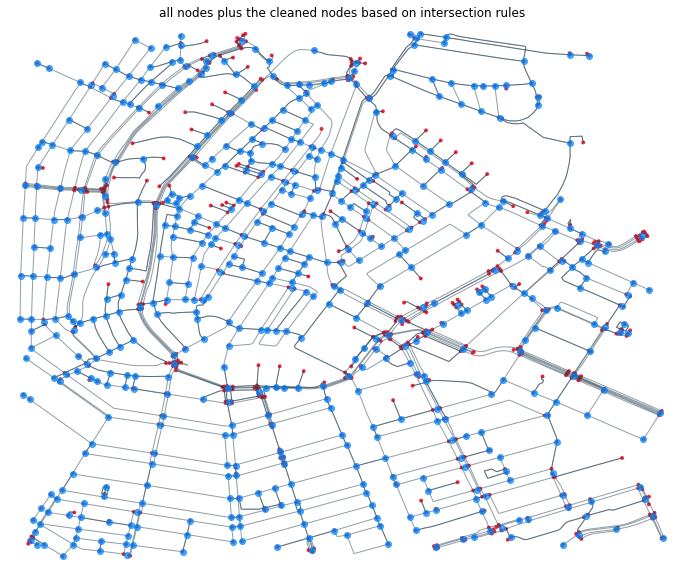

In [36]:
# plot the cleaned-up intersections
fig, ax = ox.plot_graph(G_proj, show=False, close=False, **graph_settings)
# overlay the reduced intersections
ax.scatter(x=points[:,0], y=points[:,1], zorder=2, color='#0088FF', alpha=.7)
_ = ax.set(title = 'all nodes plus the cleaned nodes based on intersection rules')
plt.show()

### demo walkeable distances

In [37]:
df_nodes = ox.graph_to_gdfs(G, nodes=True, edges=False)

In [38]:
x, y = df_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))

In [39]:
network_type = 'walk'
trip_times = [1, 3, 5, 7, 10] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [40]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [57]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='plasma', start=0.3, return_hex=True)

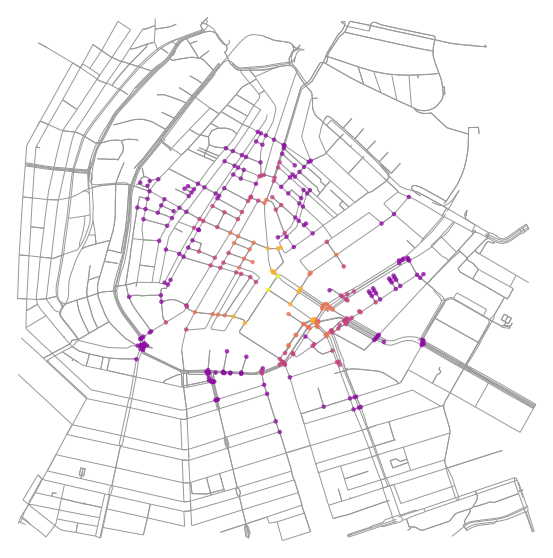

In [58]:
# color the nodes according to isochrone then plot the street network

node_colors = {}

for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    
    for node in subgraph.nodes():
        node_colors[node] = color
        
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]

fig, ax = ox.plot_graph(G, fig_height=graph_settings['fig_height'], 
                        fig_width = graph_settings['fig_width'],
                        node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [52]:
from shapely.geometry import Point, LineString, Polygon
from descartes import PolygonPatch
import geopandas as gpd
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

ValueError: A polygon or multi-polygon representation is required

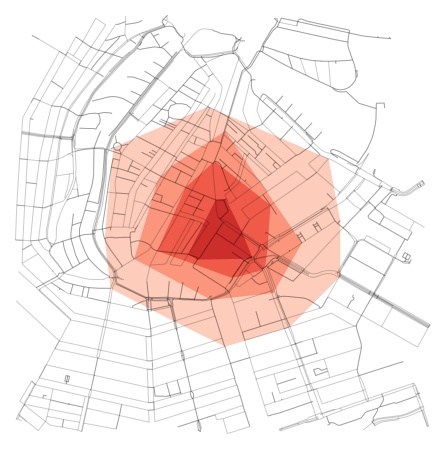

In [53]:
#plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

### save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)

In [46]:
ox.save_graph_shapefile(G, filename='mynetwork_shapefile', folder = OUTPUT_PATH)
ox.save_graphml(G, filename='mynetwork.xml',folder= OUTPUT_PATH)